# Diagrams

This notebook generates all the diagrams for the paper.

In [66]:
from os.path import exists
from copy import deepcopy
import numpy
from geopandas import GeoDataFrame, GeoSeries, read_file

from sensor_placement import *
from sensor_placement.data import *
from sensor_placement.matplotlib import *

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint, shape
from shapely.ops import cascaded_union, nearest_points, voronoi_diagram
from shapely.affinity import translate

import logging
#logging.basicConfig(level=logging.DEBUG)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm, ListedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
from matplotlib.collections import PolyCollection

## General approach

In [2]:
boundary = Polygon([Point(0.0, 0.0),
                    Point(0.0, 1.0),
                    Point(1.0, 1.0),
                    Point(1.0, 0.0)])

In [192]:
points = [Point(0.25, 0.25), Point(0.75, 0.4), Point(0.4, 0.85)]
df_samples = GeoDataFrame(points, columns=['geometry'])

In [193]:
pointsPer = 100

dx = 1 / (pointsPer + 1)
xs = [ (x + 1) * dx for x in range(pointsPer)]
ys = [ (pointsPer - y) * dx for y in range(pointsPer)]

In [194]:
bxs, bys = boundary.exterior.coords.xy

/home/sd80/programming/sensor-placement/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


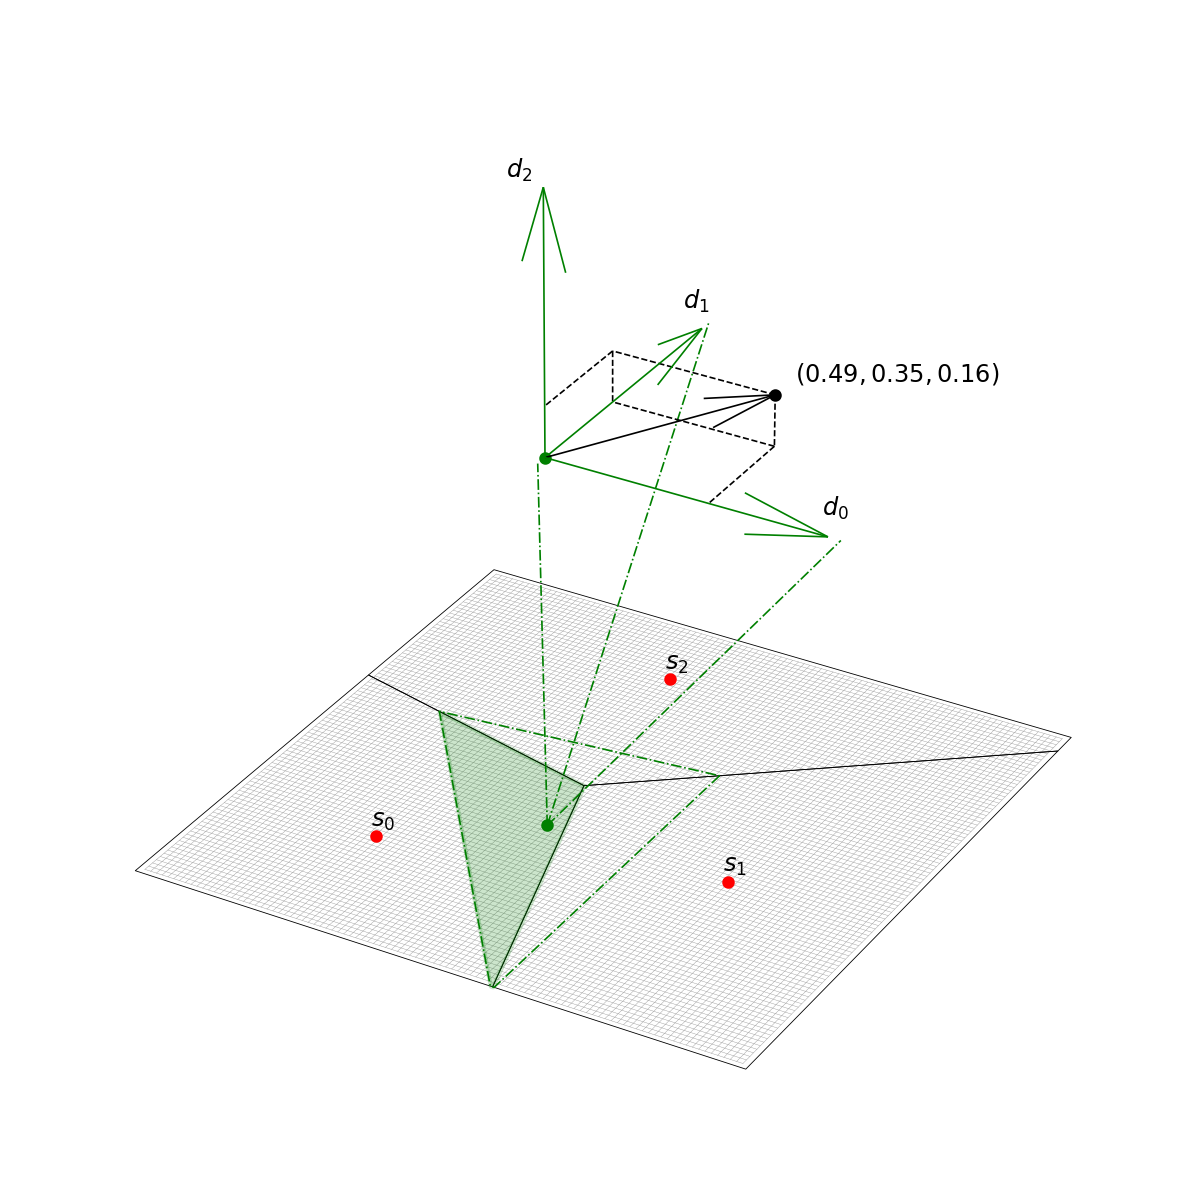

In [200]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d', xticks=[], yticks=[], zticks=[])
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_zlim([0.0, 0.8])
ax.set_frame_on(False)
ax.axis('off')
db = 0.02

# draw interpolation grid lines
for y in ys:
    ax.plot(xs, [y] * len(xs), color='0.6', linewidth=0.1)
for x in ys:
    ax.plot([x] * len(xs), ys, color='0.6', linewidth=0.1)
    
# draw sample points
for i in df_samples.geometry.index:
    pt = df_samples.geometry.loc[i]
    x, y = pt.coords.xy
    ax.plot(x[0], y[0], marker='o', color='r', markersize=2)
    ax.text(x[0] - db, y[0] + db, 0.0, f'$s_{i}$', fontsize='xx-small')

# Voronoi cells
real_points = list(df_samples.geometry)
raw_voronoi_cells = voronoi_diagram(MultiPoint(real_points), boundary)

# put cells into sample point order
voronoi_cells = []
for i in df_samples.index:
    pt = df_samples.geometry.loc[i]
    c = [c for c in raw_voronoi_cells if c.contains(pt)][0]
    voronoi_cells.append(c.intersection(boundary))
    
# draw cells
for c in voronoi_cells:
    x, y = c.exterior.xy
    ax.plot(x, y, color='k', linewidth=0.2)

# interpolation point
ix, iy = 0.45, 0.40

# synthetic cell
synthetic_points = real_points + [Point(ix, iy)]
synthetic_voronoi_cells =  voronoi_diagram(MultiPoint(synthetic_points), boundary)
synthetic_c = [synthetic_voronoi_cells.geoms[i] for i in range(len(synthetic_voronoi_cells.geoms)) if Point(ix, iy).within(synthetic_voronoi_cells.geoms[i])][0]

# draw synthetic cell
x, y = synthetic_c.intersection(boundary).exterior.xy
ax.plot(x, y, color='g', linestyle='-.', linewidth=0.4)

# weights
w = []
synthetic_area = synthetic_c.area
for c in voronoi_cells:
    area = c.intersection(synthetic_c).area
    w.append(area / synthetic_area)

# chosen overlap to highlight
ci = 0
chosen = voronoi_cells[ci].intersection(synthetic_c)
vertices = [list(chosen.exterior.coords)]
poly = PolyCollection(vertices, color='g')
poly.set_alpha(0.2)
ax.add_collection3d(poly)
    
# annotate overlap with its weight
x, y = chosen.centroid.coords.xy

# draw and label vector space axes
iz = 0.65
dx = 0.45
ax.plot(ix, iy, iz, marker='o', color='g', markersize=2)
ax.quiver(ix, iy, iz, dx, 0.0, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, dx, 0.0, color='g', linewidth=0.4)
ax.quiver(ix, iy, iz, 0.0, 0.0, dx, color='g', linewidth=0.4)
ax.text(ix + dx - db, iy + db, iz + db, '$d_0$', fontsize='xx-small')
ax.text(ix - db, iy + dx - db, iz + 2 * db, '$d_1$', fontsize='xx-small')
ax.text(ix - 3 * db, iy, iz + dx, '$d_2$', fontsize='xx-small')

# explode interpolation point to axes
ax.plot(ix, iy, 0.0, marker='o', color='g', markersize=2)
ax.plot([ix, ix], [iy, iy - db], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)
ax.plot([ix, ix + dx + db], [iy, iy], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)
ax.plot([ix, ix], [iy, iy + dx + db], [0.0, iz], color='g', linestyle='-.', linewidth=0.4)

# draw weight covector
dw = 1.2 * dx
wx, wy, wz = ix + w[0] * dw, iy + w[1] * dw, iz + w[2] * dw
ax.quiver(ix, iy, iz, w[0] * dw, w[1] * dw, w[2] * dw, color='k', linewidth=0.4)
ax.plot(wx, wy, wz, marker='o', color='k', markersize=2)
ax.text(wx + db, wy + db, wz + db,
       '$({wx:.2f}, {wy:.2f}, {wz:.2f})$'.format(wx=w[0], wy = w[1], wz=w[2]), fontsize='xx-small')

# draw lines from covector to axes
ax.plot([wx, ix], [wy, wy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, iy], [wz, wz], color='k', linestyle='--', linewidth=0.4)
ax.plot([ix, ix], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, wy], [wz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, wx], [wy, iy], [iz, iz], color='k', linestyle='--', linewidth=0.4)
ax.plot([wx, ix], [wy, wy], [iz, iz], color='k', linestyle='--', linewidth=0.4)
    
plt.savefig('diagrams/interpolation-vector-space.png')
_ = plt.show()